In [3]:
import pandas as pd
import re
import numpy as np
import json
import os
import folium
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [4]:
combined=pd.DataFrame()
path=r'C:\Users\Bekbol\Desktop\relog'
json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
for i in range(len(json_files)):
    file=os.path.join(path, json_files[i])
    data = json.load(open(file))
    file_names=pd.DataFrame.from_dict(data, orient='columns')
    locations=pd.json_normalize(data['locations'])
    result = pd.concat([file_names, locations], axis=1, join="inner")
    A=np.asarray(data['matrix'])
    json_files[i]=pd.concat([result,pd.DataFrame(A)],axis=1,ignore_index=True)
    json_files[i].drop([0,1],axis=1, inplace=True)
    #combined=combined.append(temp,ignore_index=True)  
    

In [138]:
test1=json_files[0]
test1=test1.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
test2=json_files[1]
test2=test2.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
test3=json_files[2]
test3=test3.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
test4=json_files[3]
test4=test4.rename(columns={2: 'K', 3:'lat', 4: 'lng'})
result1=test1.copy()
result2=test2.copy()
result3=test3.copy()
result4=test4.copy()

In [6]:
print(result1.describe().T)
print(result2.describe().T)
print(result3.describe().T)
print(result4.describe().T)

     count          mean          std        min          25%           50%  \
K    972.0     30.000000     0.000000  30.000000    30.000000     30.000000   
lat  972.0     43.250994     0.037501  43.123632    43.229708     43.246060   
lng  972.0     76.910736     0.042077  76.777349    76.879965     76.912133   
5    972.0  11203.723148  6810.423186   0.000000  5297.500000  11899.650000   
6    972.0   6624.780247  4407.226243   0.000000  3915.075000   5733.500000   
..     ...           ...          ...        ...          ...           ...   
972  972.0  10168.464300  5469.767472   0.000000  5946.775000   9398.600000   
973  972.0  10719.485288  6034.792496   0.000000  5671.825000  10708.050000   
974  972.0  12272.484774  4875.539475   0.000000  8967.850000  11564.100000   
975  972.0   8945.942387  5348.955211   0.000000  4482.700000   8427.750000   
976  972.0   7136.619033  4899.936331   0.000000  3231.925000   5644.800000   

              75%           max  
K       30.000000

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Bekbol\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-91967f61b311>", line 2, in <module>
    print(result2.describe().T)
  File "C:\Users\Bekbol\anaconda3\lib\site-packages\pandas\core\generic.py", line 9938, in describe
    ldesc = [describe_1d(s) for _, s in data.items()]
  File "C:\Users\Bekbol\anaconda3\lib\site-packages\pandas\core\generic.py", line 9938, in <listcomp>
    ldesc = [describe_1d(s) for _, s in data.items()]
  File "C:\Users\Bekbol\anaconda3\lib\site-packages\pandas\core\generic.py", line 9917, in describe_1d
    return describe_numeric_1d(data)
  File "C:\Users\Bekbol\anaconda3\lib\site-packages\pandas\core\generic.py", line 9870, in describe_numeric_1d
    + series.quantile(percentiles).tolist()
  File "C:\Users\Bekbol\anaconda3\lib\site-packages\pandas\core\series.py", line 2199, in quantile
    

TypeError: object of type 'NoneType' has no len()

In [139]:
def create_clusters(table):
    new=pd.DataFrame()    
    number_of_clusters=table.K.unique().tolist()    
    for i in range(0,len(number_of_clusters)):
        temp=table[table['K'].isin([number_of_clusters[i]])]       
        points=list(zip(temp.lat,temp.lng))
        kmeans = MiniBatchKMeans(n_clusters=number_of_clusters[i], batch_size=10000).fit(points)        
        l_array = np.array([[label] for label in kmeans.labels_])
        clusters = np.append(points,l_array,axis=1)
        temp_claster=pd.DataFrame(clusters, columns=['lat','lng','label'])        
        temp2 =temp.merge(temp_claster,on=['lat','lng'],how='left')
        new=new.append(temp2,ignore_index=True)                   
    return new

In [140]:
new1=create_clusters(result1)
new2=create_clusters(result2)
new3=create_clusters(result3)
new4=create_clusters(result4)

In [63]:
new1.duplicated(subset=['lat', 'lng']).values.any()

False

In [64]:
new2.duplicated(subset=['lat', 'lng']).values.any()

False

In [65]:
new3.duplicated(subset=['lat', 'lng']).values.any()

False

In [66]:
new4.duplicated(subset=['lat', 'lng']).values.any()

False

In [67]:
print(new1.shape)
print(new2.shape)
print(new3.shape)
print(new4.shape)

(972, 976)
(4573, 4577)
(151, 155)
(477, 481)


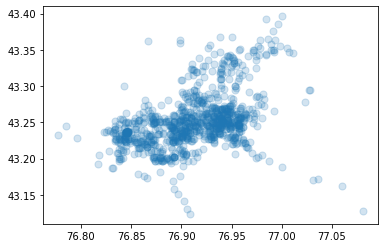

In [68]:
X = np.array(new1[['lng', 'lat']], dtype='float64')
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

In [69]:
m = folium.Map(location=[new1.lat.mean(), new1.lng.mean()], zoom_start=9, 
               tiles='OpenStreet Map')
for _, row in new1.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lng],
        radius=5,
        #popup=re.sub(r'[^a-zA-Z ]+', '', row.K),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

m

# Algorithms

1. K Means Clustering


2. Hierarchical Clustering

3. K Mode Clustering

4. DBScan Clustering — Density-Based Spatial Clustering


In [135]:
################################################################

# 1. K means clusterin does not work with pair matrix (distance). Computing the arithmetic mean requires access to the original features, a distance matrix cannot be used. So the distance matrix is useless for this algorithm.


In [136]:
################################################################

# 2.Hierarchical Clustering

In [137]:
new1.head()

,K,lat,lng,5,6,7,8,9,10,11,...,969,970,971,972,973,974,975,976,label,agglomer
0,30,43.228997,76.852695,0.0,4628.4,11408.3,2146.1,331.6,7557.1,6304.9,...,12254.5,18354.7,1040.1,18812.6,1915.1,15625.7,14754.6,7790.2,27.0,0.0
1,30,43.244314,76.889528,5299.5,0.0,6113.0,6331.9,5443.6,8353.8,7744.1,...,7509.2,9200.5,6152.1,9658.4,5673.1,10880.4,9459.3,4855.9,23.0,0.0
2,30,43.269388,76.934788,14056.8,6625.8,0.0,10444.1,13725.3,11966.6,16052.4,...,3760.8,3087.6,11571.7,3545.5,11158.6,8122.8,3346.3,3806.5,16.0,1.0
3,30,43.220679,76.870008,1996.7,3985.2,10058.3,0.0,2140.8,3560.3,2554.0,...,14486.2,13145.9,3477.1,13603.8,4146.8,17857.4,11326.5,7460.9,13.0,0.0
4,30,43.227579,76.849918,331.6,4772.5,11076.7,2290.2,0.0,7225.5,5973.3,...,11923.0,18023.2,708.5,18481.1,1583.5,15294.2,14423.1,15474.6,27.0,0.0


In [141]:
distance_matrix=new1.iloc[:, 3:975]

In [173]:
coordinates=new1.iloc[:, 1:3]

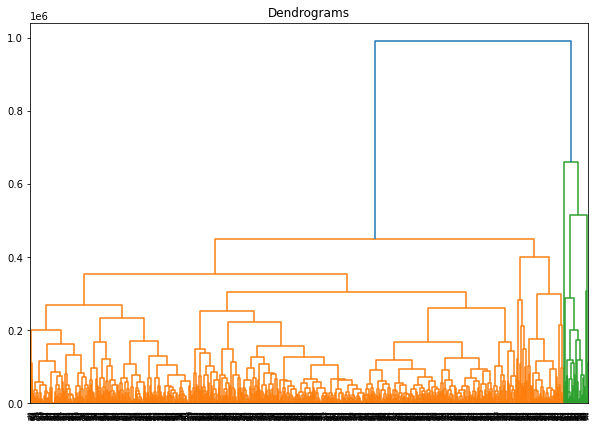

In [193]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(distance_matrix, method='complete'))

In [201]:
from sklearn.cluster import AgglomerativeClustering
ahc = AgglomerativeClustering(n_clusters=40, affinity='euclidean', linkage='ward')
ahc.fit_predict(distance_matrix)


array([ 5, 16,  6,  3,  5,  4,  4, 20,  1,  4, 10, 10,  6,  3,  9, 20,  1,
       38,  1, 15,  6, 15, 39,  6, 26, 15, 13,  2, 17, 17,  2, 11, 26, 16,
        6, 15,  0,  6, 17, 18,  5, 16, 10, 37,  8,  2, 17, 33,  4, 13,  9,
       20,  5, 11,  7,  6, 17,  1, 11, 11, 14, 26,  5,  8,  2,  9, 18,  9,
        3, 10,  4,  4,  8,  4, 36, 21, 10, 34,  5,  6, 17, 15, 24, 20, 26,
        5,  0, 12, 17,  6,  8, 30,  9, 12,  5,  6, 36, 38, 39, 25, 25,  0,
        3, 16, 29, 18, 17, 26, 13, 26, 22, 10, 10, 34,  0, 19, 32,  6,  9,
        4,  8, 19,  2, 16,  3, 19, 35,  3, 13, 26, 25,  5, 12,  5,  9,  0,
       17, 15, 17, 24,  6,  2, 14,  6,  8, 34,  0,  8, 15, 34,  4, 24,  9,
       17,  7,  9, 16,  5, 12, 23, 33,  4, 39, 39,  4,  9,  0,  6,  4,  0,
       10,  6, 16,  4, 18, 38, 38, 36, 12,  4, 20, 31, 12, 25, 12,  0,  1,
       10, 26, 31, 35,  1, 27, 12,  1, 33,  6,  6,  5, 38,  9, 22, 19,  0,
        0, 10,  9,  5, 18, 31, 15, 26, 33, 33,  6, 15, 11,  6, 26, 15, 33,
        8,  5, 32, 18, 18

In [202]:
for i in range(len(ahc.labels_)):
    new1.at[i,'hierarchy']=ahc.labels_[i]

In [203]:
new1.head()

,K,lat,lng,5,6,7,8,9,10,11,...,969,970,971,972,973,974,975,976,label,hierarchy
0,30,43.228997,76.852695,0.0,4628.4,11408.3,2146.1,331.6,7557.1,6304.9,...,12254.5,18354.7,1040.1,18812.6,1915.1,15625.7,14754.6,7790.2,18.0,5.0
1,30,43.244314,76.889528,5299.5,0.0,6113.0,6331.9,5443.6,8353.8,7744.1,...,7509.2,9200.5,6152.1,9658.4,5673.1,10880.4,9459.3,4855.9,7.0,16.0
2,30,43.269388,76.934788,14056.8,6625.8,0.0,10444.1,13725.3,11966.6,16052.4,...,3760.8,3087.6,11571.7,3545.5,11158.6,8122.8,3346.3,3806.5,4.0,6.0
3,30,43.220679,76.870008,1996.7,3985.2,10058.3,0.0,2140.8,3560.3,2554.0,...,14486.2,13145.9,3477.1,13603.8,4146.8,17857.4,11326.5,7460.9,23.0,3.0
4,30,43.227579,76.849918,331.6,4772.5,11076.7,2290.2,0.0,7225.5,5973.3,...,11923.0,18023.2,708.5,18481.1,1583.5,15294.2,14423.1,15474.6,18.0,5.0


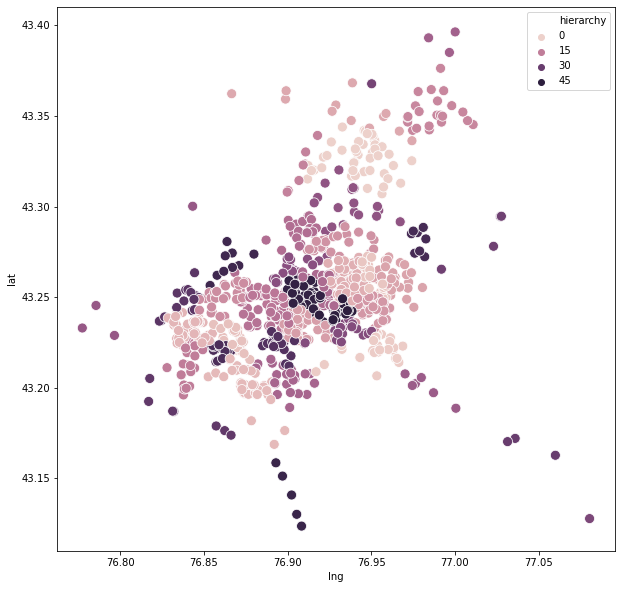

In [204]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=new1, x='lng', y='lat', hue='hierarchy',s=100)